# SHAP Analysis for XGBoost Final Model — `SHAP.ipynb`

### Description  
This notebook explains and visualizes the predictions made by the **final XGBoost model** using **SHAP (SHapley Additive exPlanations)**.  
It focuses on model interpretability — understanding *why* the model predicts a trial as successful or failed.

### Key Steps  
- Load the final XGBoost model (`xgb_pipeline.pkl`) and grouped dataset (`df_final_grouped.csv`).  
- Compute SHAP values using `shap.TreeExplainer`.  
- Generate interpretability outputs:
  - **Global Explanations** — SHAP summary and feature importance plots.  
  - **Feature Interactions** — Detect top interacting variables.  
  - **Dependence Plots** — Visualize how numerical and categorical features influence model output.  
  - **Waterfall Plots** — Local explanations for one high-confidence success, one failure, and one mid-case trial.  
- Save all plots and data to `../results/shap_outputs/` for reproducibility.

### Outputs  
All plots and CSVs are stored in:  
📂 `../results/shap_outputs/`

| Output File | Description |
|--------------|-------------|
| `shap_summary_plot.png` | Global SHAP summary visualization |
| `shap_bar_plot.png` | Mean absolute SHAP feature importance |
| `shap_feature_importance.csv` | Tabular feature importance summary |
| `shap_interacting_features.csv` | Top feature interactions |
| `dep_*.png` | Dependence plots for key features |
| `waterfall_*.png` | Local explanations (success, failure, mid-case) |

In [1]:
import os
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Setup paths
RESULTS_DIR = "../results/shap_outputs"
os.makedirs(RESULTS_DIR, exist_ok=True)

# === 2. Load model and dataset ===
xgb_final = joblib.load("../models/xgb_pipeline.pkl")
df_final = pd.read_csv("../data/final/df_final_grouped.csv")

X = df_final.drop(columns=["overall_status", "nct_id", "high_enroll_flag_99"])
y = df_final["overall_status"]

# Encode categorical features
X_encoded = X.copy()
for col in X.select_dtypes("object").columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

print("X_test shape:", X_test.shape) 

X_test shape: (52628, 21)


In [3]:
# Build SHAP explainer
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer(X_test)

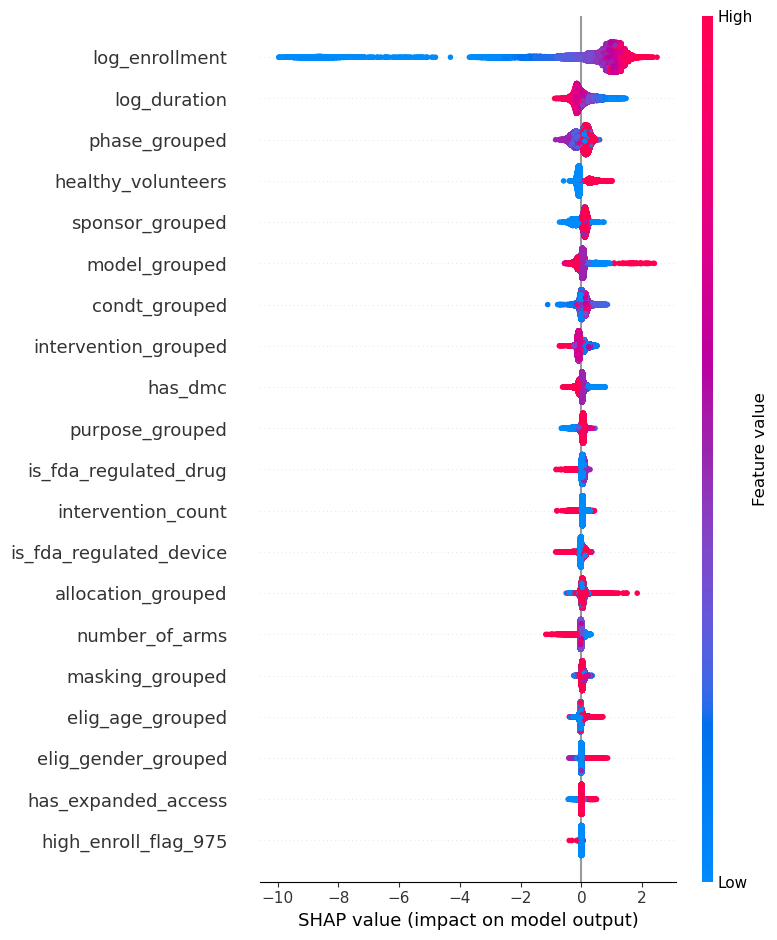

In [4]:
# SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig(os.path.join(RESULTS_DIR, "shap_summary_plot.png"), dpi=300, bbox_inches="tight")
plt.show()

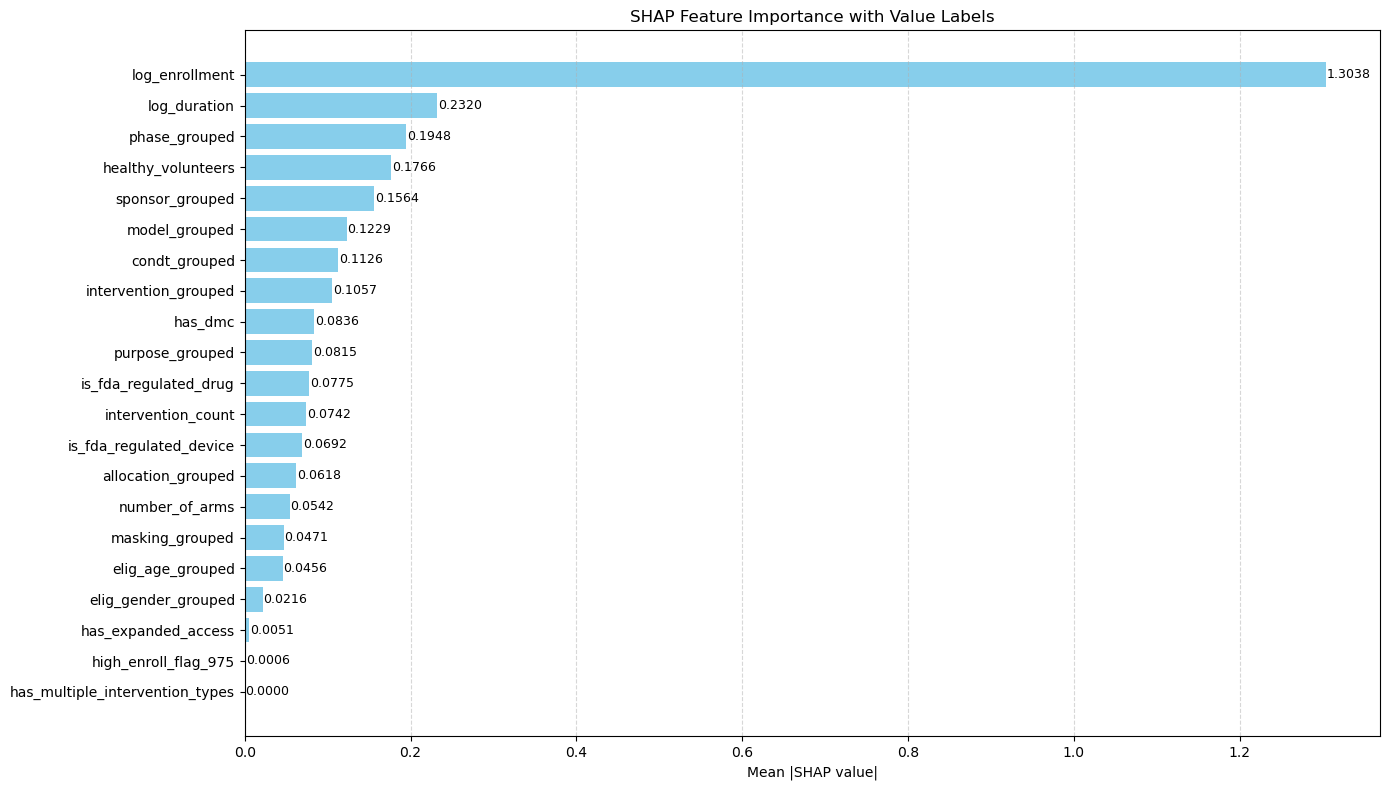

In [5]:
# Bar plot of mean SHAP values
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=True).reset_index(drop=True)

shap_df.to_csv(os.path.join(RESULTS_DIR, "shap_feature_importance.csv"), index=False)

plt.figure(figsize=(14, 8))
bars = plt.barh(shap_df['feature'], shap_df['mean_abs_shap'], color='skyblue')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', fontsize=9)
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Feature Importance with Value Labels")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "shap_bar_plot.png"), dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# SHAP Interaction analysis
features = [c for c in df_final if c not in ('high_enroll_flag_99', 'nct_id', 
                                             'has_expanded_access', 'overall_status', 
                                             'has_multiple_intervention_types')]
top_interactions = []

for feat in features:
    interaction_scores = shap.utils.approximate_interactions(feat, shap_values.values, X_test)
    
    interaction_values = [
        shap_values.values[:, features.index(feat)] * shap_values.values[:, i]
        for i in interaction_scores
    ]
    
    mean_interactions = [np.mean(np.abs(val)) for val in interaction_values]
    interactor_names = [X_test.columns[i] for i in interaction_scores]
    
    top_interactions.append({
        'Main feature': feat,
        'Top interacting feature': interactor_names[0],
        'Top interaction value': round(mean_interactions[0], 3)
    })

df_shap_interactions = pd.DataFrame(top_interactions).sort_values(by='Top interaction value', ascending=False).reset_index(drop=True)
df_shap_interactions.to_csv(os.path.join(RESULTS_DIR, "shap_interacting_features.csv"), index=False)

df_shap_interactions.head(10)

,Main feature,Top interacting feature,Top interaction value
0,log_duration,phase_grouped,0.229
1,is_fda_regulated_device,log_enrollment,0.187
2,elig_age_grouped,log_enrollment,0.168
3,allocation_grouped,log_enrollment,0.123
4,elig_gender_grouped,log_enrollment,0.088
5,model_grouped,log_enrollment,0.079
6,purpose_grouped,log_enrollment,0.062
7,number_of_arms,log_enrollment,0.058
8,condt_grouped,log_duration,0.043
9,sponsor_grouped,log_duration,0.036


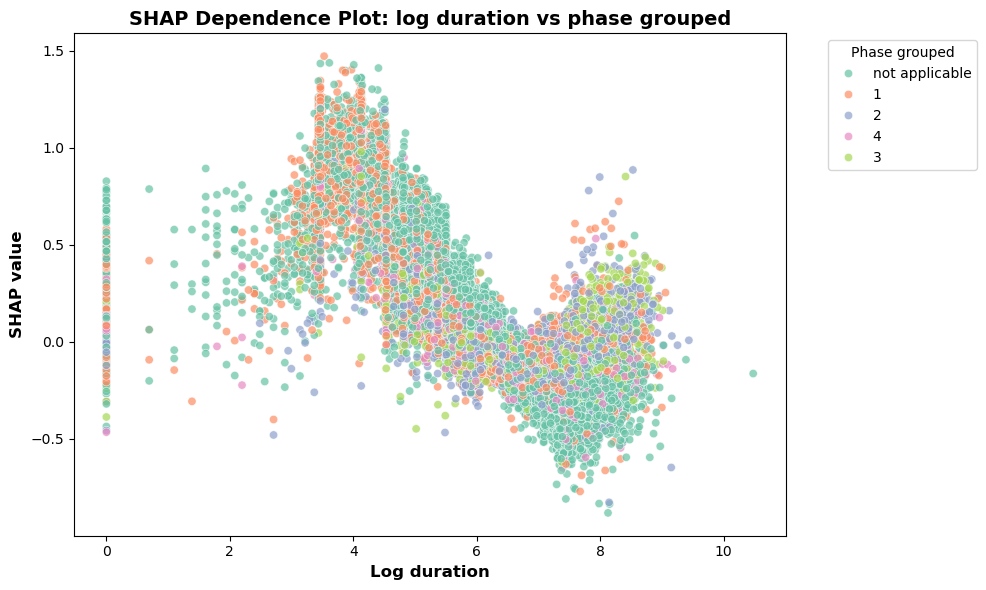

In [7]:
# Dependence plot: log duration vs phase grouped
le_phase = LabelEncoder()
le_phase.fit(X['phase_grouped']) 

phase_mapping = dict(zip(le_phase.transform(le_phase.classes_), le_phase.classes_))

X_vis = X_test.copy()
X_vis['phase_grouped'] = X_test['phase_grouped'].map(phase_mapping).fillna("Unknown")
shap_val = shap_values.values[:, X_test.columns.get_loc('log_duration')]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_test['log_duration'],
    y=shap_val,
    hue=X_vis['phase_grouped'],
    palette='Set2',
    alpha=0.7
)

plt.xlabel('Log duration', fontsize=12, fontweight='bold')
plt.ylabel('SHAP value', fontsize=12, fontweight='bold')
plt.title('SHAP Dependence Plot: log duration vs phase grouped', fontsize=14, fontweight='bold')
plt.legend(title='Phase grouped', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "dep_log_duration_phase.png"), dpi=300, bbox_inches="tight")
plt.show()


In [8]:
# Dependence plots for categorical features
def shap_dependence_categorical_plot(top_feature, interaction_feature,
                                     shap_values, X_test_encoded, original_df, filename, show=False):
    le = LabelEncoder()
    le.fit(original_df[top_feature])
    mapping = dict(zip(le.transform(le.classes_), le.classes_))

    plt.figure(figsize=(12, 8))
    shap.dependence_plot(
        ind=top_feature,
        shap_values=shap_values.values,
        features=X_test_encoded,
        interaction_index=interaction_feature,
        show=False  
    )
    
    plt.xticks(ticks=list(mapping.keys()),
               labels=list(mapping.values()),
               rotation=45, ha='right', fontsize=10)
    plt.xlabel(top_feature.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    plt.ylabel("SHAP value", fontsize=12, fontweight='bold')
    plt.title(f"SHAP Dependence Plot: {top_feature.replace('_', ' ')} vs {interaction_feature.replace('_', ' ')}",
              fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(RESULTS_DIR, filename), dpi=300, bbox_inches="tight")

    # Show the plot only if requested
    if show:
        plt.show()
    else:
        plt.close()


<Figure size 1200x800 with 0 Axes>

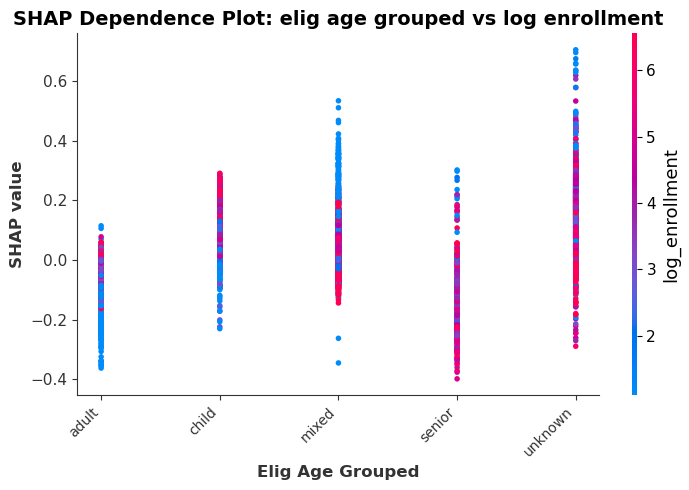

In [9]:
shap_dependence_categorical_plot('elig_age_grouped', 'log_enrollment', shap_values, 
                                 X_test, X, "dep_elig_age_enroll.png", show=True)


<Figure size 1200x800 with 0 Axes>

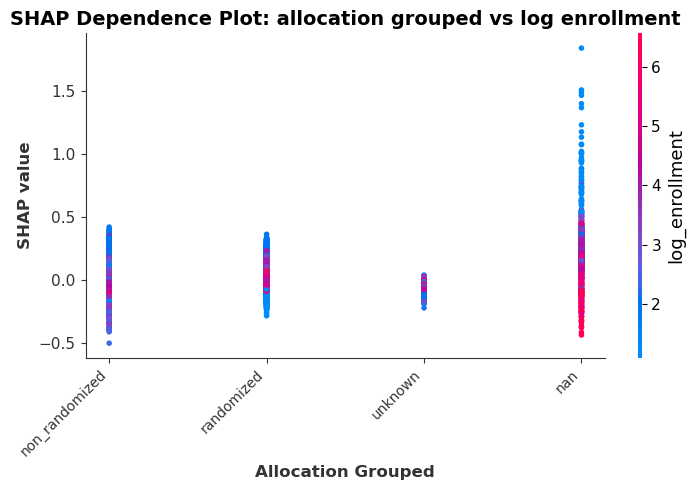

In [10]:
shap_dependence_categorical_plot('allocation_grouped', 'log_enrollment', shap_values, 
                                 X_test, X, "dep_allocation_enroll.png", show=True)


In [11]:
shap_dependence_categorical_plot('elig_gender_grouped', 'log_enrollment', shap_values, 
                                 X_test, X, "dep_elig_gender_enroll.png")
shap_dependence_categorical_plot('model_grouped', 'log_enrollment', shap_values, 
                                 X_test, X, "dep_model_enroll.png")
shap_dependence_categorical_plot('purpose_grouped', 'log_enrollment', shap_values, 
                                 X_test, X, "dep_purpose_enroll.png")


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

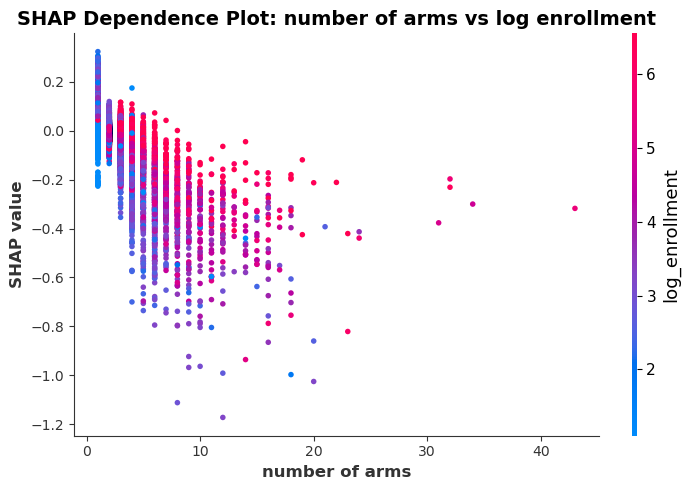

In [12]:
# Numeric dependence plot (arms vs enrollment)
plt.figure(figsize=(12, 8))  

shap.dependence_plot(
    ind='number_of_arms',
    shap_values=shap_values.values,
    features=X_test,
    interaction_index='log_enrollment',
    show=False
)

plt.title('SHAP Dependence Plot: number of arms vs log enrollment', fontsize=14, fontweight='bold')
plt.xlabel('number of arms', fontsize=12, fontweight='bold')
plt.ylabel('SHAP value', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(os.path.join(RESULTS_DIR, 'dep_arms_enroll.png'), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [13]:
# Waterfall plots (success, failure, mid-case)
y_prob = xgb_final.predict_proba(X_test)[:, 1]

# Helper for labeling features with values
def clean_labels(explanation, decoded_row):
    explanation.feature_names = [
        f"{feat} ({round(decoded_row[feat], 2)})" if isinstance(decoded_row[feat], (int, float))
        else f"{feat} ({decoded_row[feat]})"
        for feat in explanation.feature_names
    ]
    return explanation

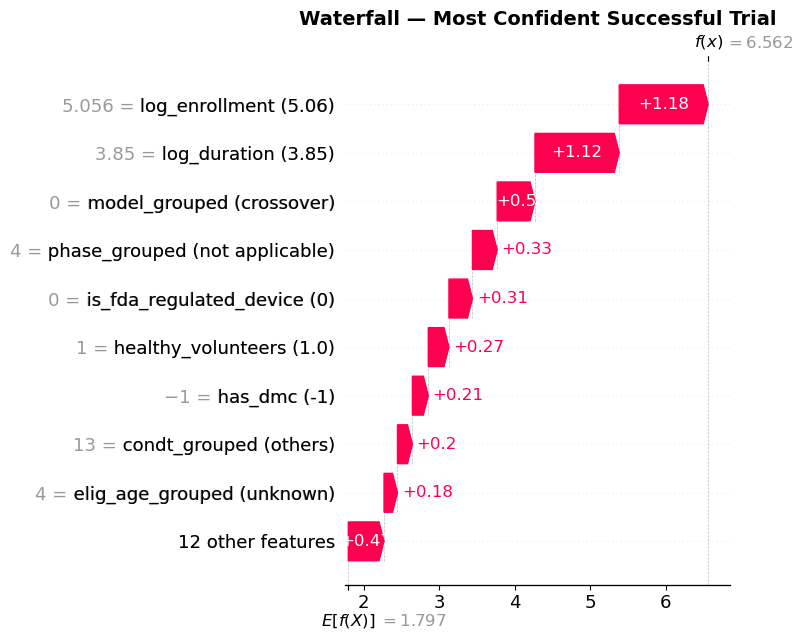

In [14]:
# Success case
success_index = np.argmax(y_prob)
success_expl = explainer(X_test.iloc[success_index:success_index+1])
decoded_row = X.iloc[X_test.index[success_index]]
success_expl_clean = clean_labels(success_expl, decoded_row)

plt.figure(figsize=(12, 8))
shap.plots.waterfall(success_expl_clean[0], show=False)
plt.title("Waterfall — Most Confident Successful Trial", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "waterfall_success.png"), dpi=300, bbox_inches="tight")
plt.show()


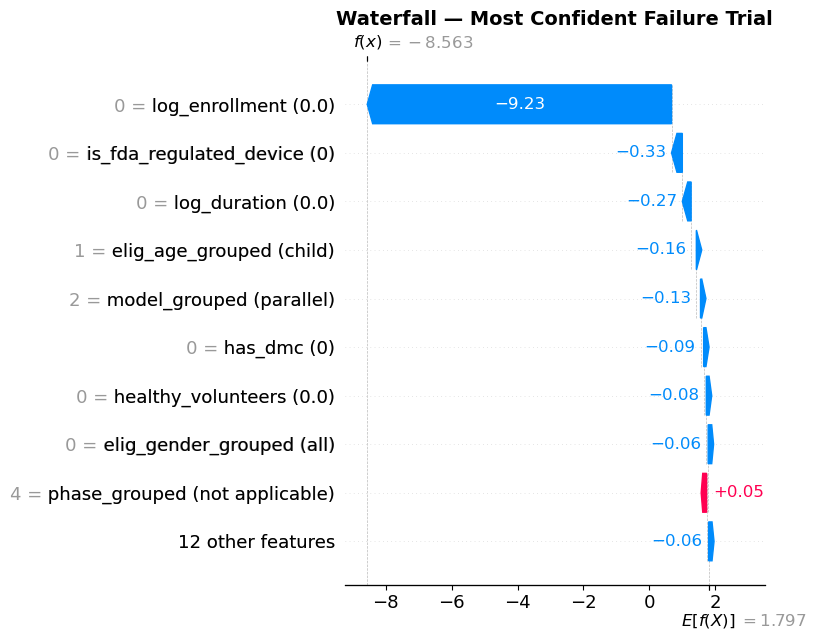

In [15]:
# Failure case
failure_index = np.argmin(y_prob)
failure_expl = explainer(X_test.iloc[failure_index:failure_index+1])
decoded_row = X.iloc[X_test.index[failure_index]]
failure_expl_clean = clean_labels(failure_expl, decoded_row)

plt.figure(figsize=(12, 8))
shap.plots.waterfall(failure_expl_clean[0], show=False)
plt.title("Waterfall — Most Confident Failure Trial", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "waterfall_failure.png"), dpi=300, bbox_inches="tight")
plt.show()

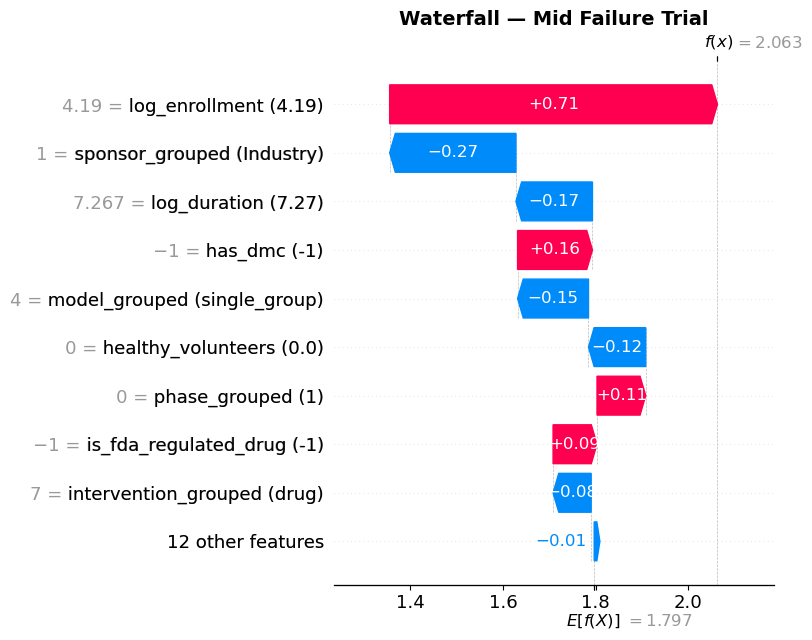

In [16]:
# Mid-case failure (25th percentile)
sorted_preds = np.argsort(y_prob)  # ascending
mid_failure_index = sorted_preds[len(sorted_preds) // 4]

mid_failure_expl = explainer(X_test.iloc[mid_failure_index:mid_failure_index+1])
decoded_row = X.iloc[X_test.index[mid_failure_index]]
mid_failure_expl_clean = clean_labels(mid_failure_expl, decoded_row)

plt.figure(figsize=(12, 8))
shap.plots.waterfall(mid_failure_expl_clean[0], show=False)
plt.title("Waterfall — Mid Failure Trial", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "waterfall_mid_failure.png"), dpi=300, bbox_inches="tight")
plt.show()


In [17]:
print("✅ All SHAP outputs saved to", RESULTS_DIR)

✅ All SHAP outputs saved to ../results/shap_outputs


---

## ✅ Summary  

The SHAP analysis provides a comprehensive view of how different clinical trial design parameters influence predicted success probability.

### 🔹 Global Insights
- **Most Influential Features:**  
  - Log enrollment, log duration, healthy volunteers, phase grouped, sponsor grouped, model grouped and condition grouped had the highest mean SHAP values.  
- **Feature Interactions:**  
  - Strong interactions observed between `phase_grouped × log duration`, `eligibility age x log enrollment`, and `allocation_grouped × log enrollment`.

### 🔹 Local Interpretability  
Waterfall plots demonstrate how individual trial features contribute positively or negatively to the model’s success prediction.  

- **Most Confident Successful Trial:**  
  - High **log_enrollment (≈ 5.0)** and longer **log_duration (≈ 3.8)** were the strongest positive drivers.  
  - Moderate contributions came from **crossover model**, **phase not applicable**, and presence of **healthy volunteers (= 1)**.  
  - These design factors collectively pushed the SHAP value above 6, leading the model to classify the trial as **highly successful**.

- **Most Confident Failure Trial:**  
  - Very low **log_enrollment (≈ 0)** and **log_duration (≈ 0)** had the largest negative impact on the prediction.  
  - A **parallel model** with **child-only participants** and lack of **FDA regulation** further reduced success probability.  
  - The combined negative SHAP effects resulted in an extremely low prediction score (**f(x) ≈ −8.5**), indicating **strong failure likelihood**.

- **Mid-Failure (Borderline) Trial:**  
  - Moderate **enrollment (≈ 4.2)** increased success odds slightly, but this was offset by negative influences from  
    **industry sponsor**, **single-group model**, and absence of **healthy volunteers**.  
  - Long duration (≈ 7.3) had a small stabilizing effect, yet overall SHAP balance stayed near neutral (**f(x) ≈ 2.0**),  
    placing the trial in the **uncertain or mid-risk zone**.

These case-level explanations show that trials with robust design fundamentals—adequate enrollment, structured masking, and balanced study models—tend to push predictions toward **success**, while low enrollment, single-group, or unregulated designs drive **failure predictions**.

---

### Key Takeaways  
- SHAP enhances **model transparency** by linking predictions to interpretable design-level factors.  
- Identifies **which features** most strongly drive model confidence and how they **interact**.  
- Confirms that the model predicts based on **design feasibility patterns**, not biological or sponsor-driven biases.

---

📂 **Next Notebook:** `app/app.py` → Integrates both Logistic Regression and XGBoost models for live deployment via Streamlit.

